# Sklearn

## Bike Sharing Demand
Задача на kaggle: https://www.kaggle.com/c/bike-sharing-demand

По историческим данным о прокате велосипедов и погодных условиях необходимо спрогнозировтаь спрос на прокат велосипедов.

В исходной постановке задачи доступно 11 признаков: https://www.kaggle.com/c/prudential-life-insurance-assessment/data

В наборе признаков присутсвуют вещественные, категориальные, и бинарные данные. 

Для демонстрации используется обучающая выборка из исходных данных train.csv, файлы для работы прилагаются.

### Библиотеки

In [1]:
from sklearn import cross_validation, grid_search, linear_model, metrics, pipeline, preprocessing

import numpy as np
import pandas as pd

/anaconda/ipython2/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/anaconda/ipython2/anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Загрузка данных

In [3]:
raw_data = pd.read_csv('bike_sharing_demand.csv', header = 0, sep = ',')

In [4]:
raw_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


### Предобработка данных

#### Обучение и отложенный тест

In [4]:
raw_data.datetime = raw_data.datetime.apply(pd.to_datetime)

In [5]:
raw_data['month'] = raw_data.datetime.apply(lambda x : x.month)
raw_data['hour'] = raw_data.datetime.apply(lambda x : x.hour)

In [6]:
train_data = raw_data.iloc[:-1000, :]
hold_out_test_data = raw_data.iloc[-1000:, :]

In [8]:
print raw_data.shape, train_data.shape, hold_out_test_data.shape

(10886, 14) (9886, 14) (1000, 14)


In [7]:
#обучение
train_labels = train_data['count'].values
train_data = train_data.drop(['datetime', 'count', 'casual', 'registered'], axis = 1)

In [8]:
#тест
test_labels = hold_out_test_data['count'].values
test_data = hold_out_test_data.drop(['datetime', 'count', 'casual', 'registered'], axis = 1)

In [9]:
binary_data_columns = ['holiday', 'workingday']
binary_data_indices = np.array([(column in binary_data_columns) for column in train_data.columns], dtype = bool)

In [12]:
print binary_data_columns
print binary_data_indices

['holiday', 'workingday']
[False  True  True False False False False False False False]


In [10]:
categorical_data_columns = ['season', 'weather', 'month'] 
categorical_data_indices = np.array([(column in categorical_data_columns) for column in train_data.columns], dtype = bool)

In [14]:
print categorical_data_columns
print categorical_data_indices

['season', 'weather', 'month']
[ True False False  True False False False False  True False]


In [11]:
numeric_data_columns = ['temp', 'atemp', 'humidity', 'windspeed', 'hour']
numeric_data_indices = np.array([(column in numeric_data_columns) for column in train_data.columns], dtype = bool)

In [16]:
print numeric_data_columns
print numeric_data_indices

['temp', 'atemp', 'humidity', 'windspeed', 'hour']
[False False False False  True  True  True  True False  True]


### Pipeline

In [17]:
regressor = linear_model.SGDRegressor(random_state = 0, n_iter = 3, loss = 'squared_loss', penalty = 'l2')

/anaconda/ipython2/anaconda/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:73: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


In [18]:
estimator = pipeline.Pipeline(steps = [       
    ('feature_processing', pipeline.FeatureUnion(transformer_list = [        
            #binary
            ('binary_variables_processing', preprocessing.FunctionTransformer(lambda data: data[:, binary_data_indices])), 
                    
            #numeric
            ('numeric_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, numeric_data_indices])),
                ('scaling', preprocessing.StandardScaler(with_mean = 0))            
                        ])),
        
            #categorical
            ('categorical_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, categorical_data_indices])),
                ('hot_encoding', preprocessing.OneHotEncoder(handle_unknown = 'ignore'))            
                        ])),
        ])),
    ('model_fitting', regressor)
    ]
)

In [19]:
estimator.fit(train_data, train_labels)

Pipeline(memory=None,
     steps=[('feature_processing', FeatureUnion(n_jobs=1,
       transformer_list=[('binary_variables_processing', FunctionTransformer(accept_sparse=False,
          func=<function <lambda> at 0x112383848>, inv_kw_args=None,
          inverse_func=None, kw_args=None, pass_y='deprecated',
          valida...,
       power_t=0.25, random_state=0, shuffle=True, tol=None, verbose=0,
       warm_start=False))])

In [20]:
metrics.mean_absolute_error(test_labels, estimator.predict(test_data))

120.17177172806856

### Подбор параметров

In [21]:
estimator.get_params().keys()

['feature_processing__binary_variables_processing__pass_y',
 'feature_processing__binary_variables_processing__func',
 'feature_processing__numeric_variables_processing__selecting__kw_args',
 'model_fitting__learning_rate',
 'feature_processing__n_jobs',
 'feature_processing__numeric_variables_processing__selecting',
 'feature_processing__categorical_variables_processing__selecting__kw_args',
 'feature_processing__numeric_variables_processing__scaling__with_std',
 'feature_processing__categorical_variables_processing__selecting__pass_y',
 'feature_processing__categorical_variables_processing__selecting__accept_sparse',
 'feature_processing__transformer_weights',
 'feature_processing__categorical_variables_processing__hot_encoding__n_values',
 'model_fitting__fit_intercept',
 'feature_processing__numeric_variables_processing__selecting__inverse_func',
 'feature_processing',
 'model_fitting__epsilon',
 'feature_processing__categorical_variables_processing__hot_encoding__handle_unknown',


In [22]:
parameters_grid = {
    'model_fitting__alpha' : [0.0001, 0.001, 0,1],
    'model_fitting__eta0' : [0.001, 0.05],
}

In [23]:
grid_cv = grid_search.GridSearchCV(estimator, parameters_grid, scoring = 'mean_absolute_error', cv = 4)

In [24]:
%%time
grid_cv.fit(train_data, train_labels)

/anaconda/ipython2/anaconda/lib/python2.7/site-packages/sklearn/metrics/scorer.py:99: DeprecationWarning: Scoring method mean_absolute_error was renamed to neg_mean_absolute_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda/ipython2/anaconda/lib/python2.7/site-packages/sklearn/metrics/scorer.py:99: DeprecationWarning: Scoring method mean_absolute_error was renamed to neg_mean_absolute_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda/ipython2/anaconda/lib/python2.7/site-packages/sklearn/metrics/scorer.py:99: DeprecationWarning: Scoring method mean_absolute_error was renamed to neg_mean_absolute_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda/ipython2/anaconda/lib/python2.7/site-packages/sklearn/metrics/scorer.py:99: DeprecationWarning: Scoring method mean_absolute_error was renamed to neg_mean_absolute_error in version 0.18 and will be removed in 0.20.
  sampl

CPU times: user 1.83 s, sys: 117 ms, total: 1.95 s
Wall time: 1.97 s


GridSearchCV(cv=4, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('feature_processing', FeatureUnion(n_jobs=1,
       transformer_list=[('binary_variables_processing', FunctionTransformer(accept_sparse=False,
          func=<function <lambda> at 0x112383848>, inv_kw_args=None,
          inverse_func=None, kw_args=None, pass_y='deprecated',
          valida...,
       power_t=0.25, random_state=0, shuffle=True, tol=None, verbose=0,
       warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'model_fitting__eta0': [0.001, 0.05], 'model_fitting__alpha': [0.0001, 0.001, 0, 1]},
       pre_dispatch='2*n_jobs', refit=True, scoring='mean_absolute_error',
       verbose=0)

In [25]:
print grid_cv.best_score_
print grid_cv.best_params_

-106.601939797
{'model_fitting__eta0': 0.05, 'model_fitting__alpha': 0.001}


### Оценка по отложенному тесту

In [26]:
test_predictions = grid_cv.best_estimator_.predict(test_data)

In [27]:
metrics.mean_absolute_error(test_labels, test_predictions)

125.11055616822884

In [28]:
print test_labels[:20]

[525 835 355 222 228 325 328 308 346 446 943 838 531 432 195 181 199  49
  17  16]


In [29]:
print test_predictions[:20]

[ 153.28859124  181.89867268  227.64068051  262.47727954  278.91095558
  279.82091706  301.6223314   333.35079391  336.28447325  348.55425173
  346.29477487  336.77206344  318.29674096  298.65247956  285.35831745
  246.0338046   252.72004984   58.96734361   66.43816405   73.90898448]


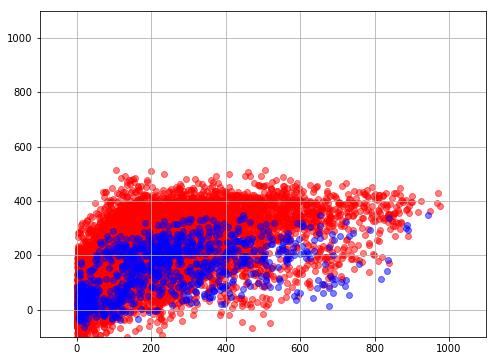

In [30]:
pylab.figure(figsize=(8, 6))
pylab.grid(True)
pylab.xlim(-100,1100)
pylab.ylim(-100,1100)
pylab.scatter(train_labels, grid_cv.best_estimator_.predict(train_data), alpha=0.5, color = 'red')
pylab.scatter(test_labels, grid_cv.best_estimator_.predict(test_data), alpha=0.5, color = 'blue')

### Другая модель

In [31]:
from sklearn.ensemble import RandomForestRegressor

In [48]:
regressor = RandomForestRegressor(random_state = 0, max_depth = 20, n_estimators = 50,criterion='mae')

In [49]:
estimator = pipeline.Pipeline(steps = [       
    ('feature_processing', pipeline.FeatureUnion(transformer_list = [        
            #binary
            ('binary_variables_processing', preprocessing.FunctionTransformer(lambda data: data[:, binary_data_indices])), 
                    
            #numeric
            ('numeric_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, numeric_data_indices])),
                ('scaling', preprocessing.StandardScaler(with_mean = 0, with_std = 1))            
                        ])),
        
            #categorical
            ('categorical_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, categorical_data_indices])),
                ('hot_encoding', preprocessing.OneHotEncoder(handle_unknown = 'ignore'))            
                        ])),
        ])),
    ('model_fitting', regressor)
    ]
)

In [50]:
estimator.fit(train_data, train_labels)

Pipeline(memory=None,
     steps=[('feature_processing', FeatureUnion(n_jobs=1,
       transformer_list=[('binary_variables_processing', FunctionTransformer(accept_sparse=False,
          func=<function <lambda> at 0x1159a4500>, inv_kw_args=None,
          inverse_func=None, kw_args=None, pass_y='deprecated',
          valida..._estimators=50, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False))])

In [51]:
metrics.mean_absolute_error(test_labels, estimator.predict(test_data))

86.510710000000003

In [35]:
metrics.mean_absolute_error(test_labels, estimator.predict(test_data))

79.477281539788123

In [36]:
test_labels[:10]

array([525, 835, 355, 222, 228, 325, 328, 308, 346, 446])

In [37]:
estimator.predict(test_data)[:10]

array([ 409.565     ,  505.56      ,  256.06066667,  165.6502619 ,
        205.82474784,  265.91960439,  254.49615818,  317.85774486,
        280.98963263,  441.59333333])

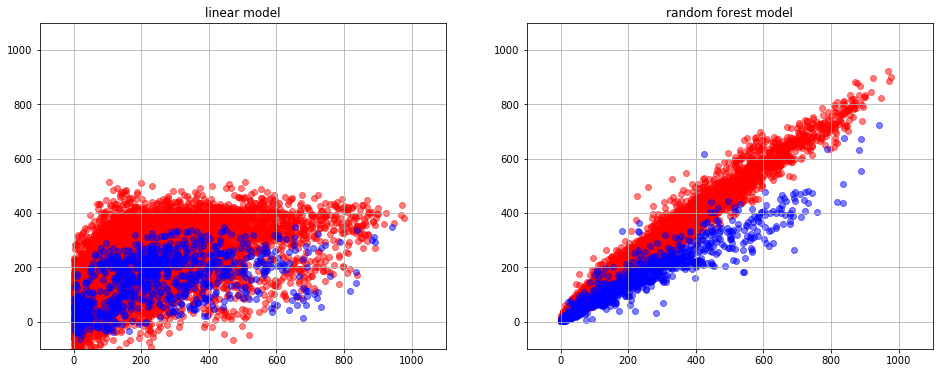

In [38]:
pylab.figure(figsize=(16, 6))

pylab.subplot(1,2,1)
pylab.grid(True)
pylab.xlim(-100,1100)
pylab.ylim(-100,1100)
pylab.scatter(train_labels, grid_cv.best_estimator_.predict(train_data), alpha=0.5, color = 'red')
pylab.scatter(test_labels, grid_cv.best_estimator_.predict(test_data), alpha=0.5, color = 'blue')
pylab.title('linear model')

pylab.subplot(1,2,2)
pylab.grid(True)
pylab.xlim(-100,1100)
pylab.ylim(-100,1100)
pylab.scatter(train_labels, estimator.predict(train_data), alpha=0.5, color = 'red')
pylab.scatter(test_labels, estimator.predict(test_data), alpha=0.5, color = 'blue')
pylab.title('random forest model')

In [56]:
parameters_grid = {
    'model_fitting__n_estimators' : [50,100],
    'model_fitting__max_depth' : [20,30]
}

In [57]:
grid_cv = grid_search.GridSearchCV(estimator, parameters_grid, scoring = 'mean_absolute_error', cv = 4)

In [ ]:
grid_cv.fit(train_data, train_labels)

In [45]:
estimator.get_params().keys()

['feature_processing__binary_variables_processing__pass_y',
 'feature_processing__binary_variables_processing__func',
 'feature_processing__numeric_variables_processing__selecting__kw_args',
 'feature_processing__n_jobs',
 'feature_processing__numeric_variables_processing__selecting',
 'feature_processing__categorical_variables_processing__selecting__kw_args',
 'feature_processing__numeric_variables_processing__scaling__with_std',
 'feature_processing__categorical_variables_processing__selecting__pass_y',
 'feature_processing__categorical_variables_processing__selecting__accept_sparse',
 'model_fitting__min_samples_split',
 'feature_processing__transformer_weights',
 'model_fitting__min_samples_leaf',
 'feature_processing__categorical_variables_processing__hot_encoding__n_values',
 'model_fitting__n_estimators',
 'model_fitting__min_impurity_split',
 'model_fitting__criterion',
 'feature_processing__numeric_variables_processing__selecting__inverse_func',
 'feature_processing',
 'featur

In [ ]:
print grid_cv.best_score_
print grid_cv.best_params_

In [12]:
import xgboost as xgb

In [38]:
regressor = xgb.XGBRegressor(learning_rate=0.1, max_depth=10, n_estimators=50, min_child_weight=3)

In [15]:
estimator = pipeline.Pipeline(steps = [       
    ('feature_processing', pipeline.FeatureUnion(transformer_list = [        
            #binary
            ('binary_variables_processing', preprocessing.FunctionTransformer(lambda data: data[:, binary_data_indices])), 
                    
            #numeric
            ('numeric_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, numeric_data_indices])),
                ('scaling', preprocessing.StandardScaler(with_mean = 0, with_std = 1))            
                        ])),
        
            #categorical
            ('categorical_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, categorical_data_indices])),
                ('hot_encoding', preprocessing.OneHotEncoder(handle_unknown = 'ignore'))            
                        ])),
        ])),
    ('model_fitting', regressor)
    ]
)

In [25]:
score = cross_validation.cross_val_score(estimator, train_data, train_labels, 
                                             scoring = 'mean_absolute_error', cv = 5)    

/anaconda/ipython2/anaconda/lib/python2.7/site-packages/sklearn/metrics/scorer.py:99: DeprecationWarning: Scoring method mean_absolute_error was renamed to neg_mean_absolute_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda/ipython2/anaconda/lib/python2.7/site-packages/sklearn/metrics/scorer.py:99: DeprecationWarning: Scoring method mean_absolute_error was renamed to neg_mean_absolute_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda/ipython2/anaconda/lib/python2.7/site-packages/sklearn/metrics/scorer.py:99: DeprecationWarning: Scoring method mean_absolute_error was renamed to neg_mean_absolute_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda/ipython2/anaconda/lib/python2.7/site-packages/sklearn/metrics/scorer.py:99: DeprecationWarning: Scoring method mean_absolute_error was renamed to neg_mean_absolute_error in version 0.18 and will be removed in 0.20.
  sampl

In [26]:
score.mean()

-83.396059674924714

In [54]:
regressor.fit(train_data,train_labels)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=3, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [28]:
metrics.mean_absolute_error(regressor.predict(test_data),test_labels)

79.246579793810838

In [34]:
metrics.mean_absolute_error(regressor.predict(test_data),test_labels)

97.858836718082429

In [37]:
metrics.mean_absolute_error(regressor.predict(test_data),test_labels)

79.77766781401634

In [41]:
metrics.mean_absolute_error(regressor.predict(test_data),test_labels)

91.259379732370377

In [42]:
regressor = xgb.XGBRegressor( max_depth=5, min_child_weight=3)

In [55]:
parameters_grid = {
    'learning_rate' : arange(0.01,0.1,0.01),
    'n_estimators' : [40,50],
}

In [56]:
grid_cv = grid_search.GridSearchCV(regressor, parameters_grid, scoring = 'mean_absolute_error', cv = 4)

In [57]:
%%time
grid_cv.fit(train_data, train_labels)

/anaconda/ipython2/anaconda/lib/python2.7/site-packages/sklearn/metrics/scorer.py:99: DeprecationWarning: Scoring method mean_absolute_error was renamed to neg_mean_absolute_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda/ipython2/anaconda/lib/python2.7/site-packages/sklearn/metrics/scorer.py:99: DeprecationWarning: Scoring method mean_absolute_error was renamed to neg_mean_absolute_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda/ipython2/anaconda/lib/python2.7/site-packages/sklearn/metrics/scorer.py:99: DeprecationWarning: Scoring method mean_absolute_error was renamed to neg_mean_absolute_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda/ipython2/anaconda/lib/python2.7/site-packages/sklearn/metrics/scorer.py:99: DeprecationWarning: Scoring method mean_absolute_error was renamed to neg_mean_absolute_error in version 0.18 and will be removed in 0.20.
  sampl

CPU times: user 21.4 s, sys: 312 ms, total: 21.7 s
Wall time: 21.9 s


GridSearchCV(cv=4, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=3, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [40, 50], 'learning_rate': array([ 0.01,  0.02,  0.03,  0.04,  0.05,  0.06,  0.07,  0.08,  0.09])},
       pre_dispatch='2*n_jobs', refit=True, scoring='mean_absolute_error',
       verbose=0)

In [46]:
print grid_cv.best_score_
print grid_cv.best_params_

-78.1364048908
{'n_estimators': 50, 'learning_rate': 0.05}


In [53]:
print grid_cv.best_score_
print grid_cv.best_params_

-78.0314133015
{'n_estimators': 40, 'learning_rate': 0.060000000000000005}


In [68]:
print grid_cv.best_score_
print grid_cv.best_params_

-78.0314133015
{'n_estimators': 40, 'learning_rate': 0.060000000000000005}


In [69]:
metrics.mean_absolute_error(grid_cv.best_estimator_.predict(test_data),test_labels)

91.593288838863373

In [70]:
regressor1 = xgb.XGBRegressor( n_estimators=40,learning_rate=0.06,max_depth=5, min_child_weight=3,booster='gblinear')

In [71]:
regressor1.fit(train_data,train_labels)
metrics.mean_absolute_error(regressor1.predict(test_data),test_labels)

130.71618452453615

In [61]:
estimator = pipeline.Pipeline(steps = [       
    ('feature_processing', pipeline.FeatureUnion(transformer_list = [        
            #binary
            ('binary_variables_processing', preprocessing.FunctionTransformer(lambda data: data[:, binary_data_indices])), 
                    
            #numeric
            ('numeric_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, numeric_data_indices])),
                ('scaling', preprocessing.StandardScaler(with_mean = 0, with_std = 1))            
                        ])),
        
            #categorical
            ('categorical_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, categorical_data_indices])),
                ('hot_encoding', preprocessing.OneHotEncoder(handle_unknown = 'ignore'))            
                        ])),
        ])),
    ('model_fitting', regressor1)
    ]
)

In [66]:
mean(cross_validation.cross_val_score(estimator, train_data, train_labels, 
                                             scoring = 'mean_absolute_error', cv = 5))

/anaconda/ipython2/anaconda/lib/python2.7/site-packages/sklearn/metrics/scorer.py:99: DeprecationWarning: Scoring method mean_absolute_error was renamed to neg_mean_absolute_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda/ipython2/anaconda/lib/python2.7/site-packages/sklearn/metrics/scorer.py:99: DeprecationWarning: Scoring method mean_absolute_error was renamed to neg_mean_absolute_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda/ipython2/anaconda/lib/python2.7/site-packages/sklearn/metrics/scorer.py:99: DeprecationWarning: Scoring method mean_absolute_error was renamed to neg_mean_absolute_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda/ipython2/anaconda/lib/python2.7/site-packages/sklearn/metrics/scorer.py:99: DeprecationWarning: Scoring method mean_absolute_error was renamed to neg_mean_absolute_error in version 0.18 and will be removed in 0.20.
  sampl

-76.440845199990619

In [64]:
estimator.fit(train_data,train_labels)

Pipeline(memory=None,
     steps=[('feature_processing', FeatureUnion(n_jobs=1,
       transformer_list=[('binary_variables_processing', FunctionTransformer(accept_sparse=False,
          func=<function <lambda> at 0x10d1a1b90>, inv_kw_args=None,
          inverse_func=None, kw_args=None, pass_y='deprecated',
          valida...
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))])

In [65]:
metrics.mean_absolute_error(estimator.predict(test_data),test_labels)

94.247933292388922

In [ ]:
estimator.